In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\USER\anaconda3\envs\AI\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\USER\anaconda3\envs\AI\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\USER\anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\USER\anaconda3\envs\AI\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\

In [2]:
dataset_path = 'data/dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names = headers,
    encoding = 'ISO-8859-1'
)

In [3]:
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
classes = {class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [5]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [6]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [7]:
df['content'].head()

0    accord gran  compani plan move product russia ...
1    technopoli plan develop stage area less 100000...
2    intern electron industri compani elcoteq laid ...
3    new product plant compani would increas capac ...
4    accord compani updat strategi year 20092012  b...
Name: content, dtype: object

In [8]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [9]:
print(f'Vocab size: {vocab_size}')

Vocab size: 8908


In [10]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except KeyError:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [11]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [12]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)

        return text, label

In [13]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

In [16]:
lr = 1e-4
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [17]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

EPOCH 1:	Train loss: 1.0102	Val loss: 0.9541
EPOCH 2:	Train loss: 0.9439	Val loss: 0.9338
EPOCH 3:	Train loss: 0.9337	Val loss: 0.9294
EPOCH 4:	Train loss: 0.9317	Val loss: 0.9286
EPOCH 5:	Train loss: 0.9311	Val loss: 0.9283
EPOCH 6:	Train loss: 0.9286	Val loss: 0.9283
EPOCH 7:	Train loss: 0.9287	Val loss: 0.9283
EPOCH 8:	Train loss: 0.9302	Val loss: 0.9284
EPOCH 9:	Train loss: 0.9311	Val loss: 0.9282
EPOCH 10:	Train loss: 0.9294	Val loss: 0.9282
EPOCH 11:	Train loss: 0.9300	Val loss: 0.9281
EPOCH 12:	Train loss: 0.9295	Val loss: 0.9283
EPOCH 13:	Train loss: 0.9283	Val loss: 0.9282
EPOCH 14:	Train loss: 0.9282	Val loss: 0.9281
EPOCH 15:	Train loss: 0.9256	Val loss: 0.9280
EPOCH 16:	Train loss: 0.9286	Val loss: 0.9279
EPOCH 17:	Train loss: 0.9276	Val loss: 0.9279
EPOCH 18:	Train loss: 0.9320	Val loss: 0.9279
EPOCH 19:	Train loss: 0.9265	Val loss: 0.9277
EPOCH 20:	Train loss: 0.9272	Val loss: 0.9277
EPOCH 21:	Train loss: 0.9270	Val loss: 0.9277
EPOCH 22:	Train loss: 0.9297	Val loss: 0.92

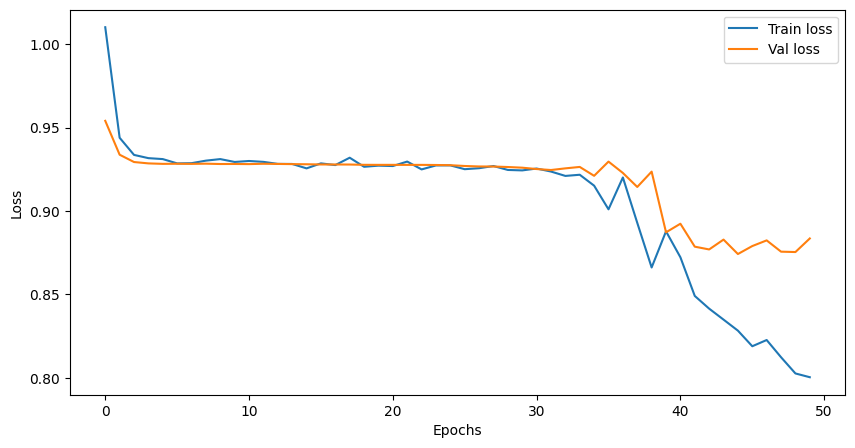

In [18]:
train_losses, val_losses = fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
)

# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset')
print('Val loss:', val_loss)
print('Val accuracy:', val_acc)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Evaluation on val / test dataset
Val loss: 0.8835677245601279
Val accuracy: 0.6257731958762887
Test loss: 0.8315214675958039
Test accuracy: 0.6309278350515464
